<a href="https://colab.research.google.com/github/MiteshBhula/AI-ML-Projects/blob/main/Mitesh_Bhula_High_Code_Plant_Seedling_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
# Importing the libraries required
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns
import sklearn.metrics as metrics

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the image file dataset
images = np.load('/content/drive/MyDrive/PG-AIML/Computer Vision/Project/images.npy')

# Loading the categorical labels file
labels = pd.read_csv('/content/drive/MyDrive/PG-AIML/Computer Vision/Project/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [ ]:
# Shape of the images dataset
print(images.shape)
# Shape of the labels dataset
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


* The shape of the images dataset is (4750, 128, 128, 3).
* This means that there are 4750 RGB images in the dataset, each image has a size of 128x128 pixels and 3 colour channels.
* The shape of the labels is 4750 rows and 1 column.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
# Function used to plot images
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

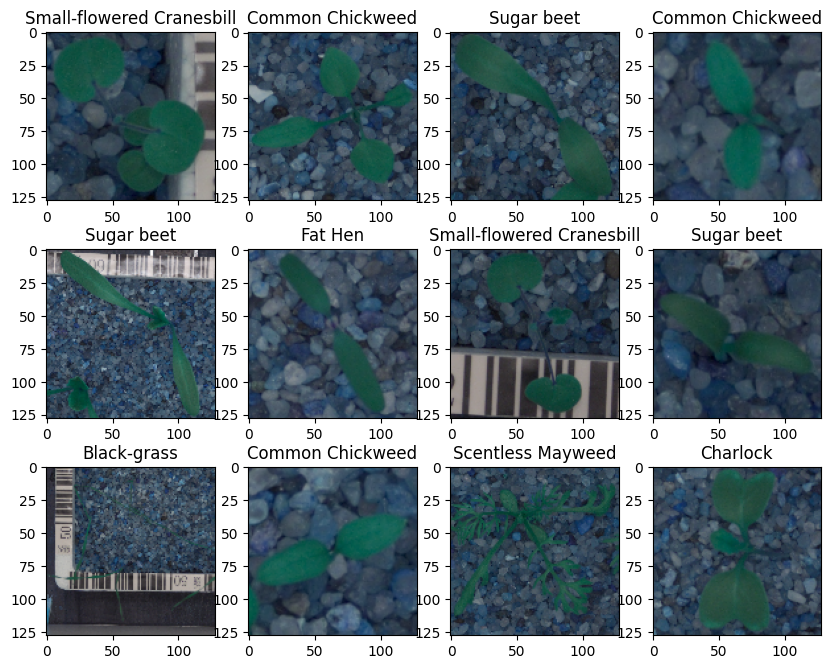

In [ ]:
plot_images(images,labels)

* From the above sample images we can see that not all the images are clear.
* Some images are brighter than others.
* One image has become difficult to distinguish from its background.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

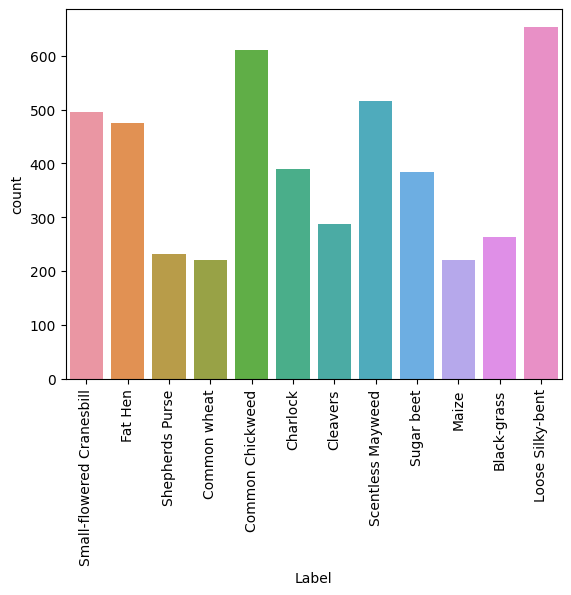

In [ ]:
# Checking for data imbalance
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

* The Loose Silky-bent label is the most common plant seedling.
* Common wheat and Maize are the least common plant seedling.  

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [ ]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation = cv2.INTER_LINEAR))

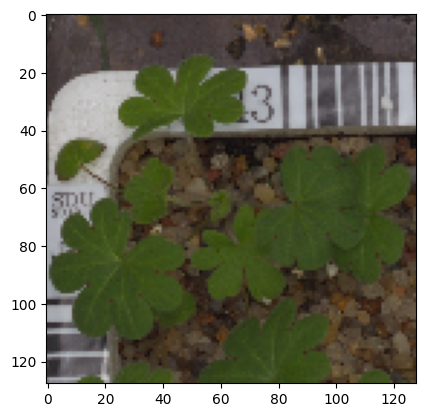

In [ ]:
# Image before resizing
plt.imshow(images[3])

* An example of an image within the dataset before resizing.

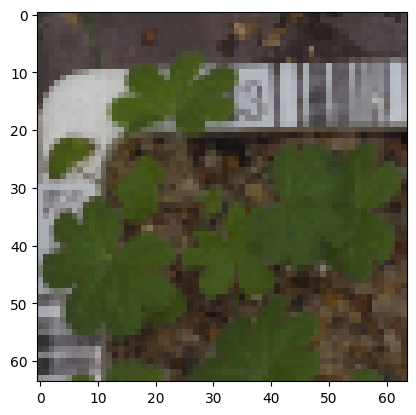

In [ ]:
# Images after resize
plt.imshow(images_decreased[3])

* An example of an image within the dataset after resizing.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(np.array(X_temp), y_temp, test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
# Printing the shape of test, train and validation sets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


* There are 3847 values within the training dataset.
* There are 428 values within the validation dataset.
* There 475 values within the test dataset.

### Encode the target labels

In [ ]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()                                        # Complete the code to intialize the labelBinarizer
y_train_encoded = enc.fit_transform(y_train)        # Complete the code to fit and transform y_train
y_val_encoded=enc.transform(y_val)                  # Complete the code to transform y_val
y_test_encoded=enc.transform(y_test)                # Complete the code to transform y_test

In [ ]:
# Shape of the encoded train, test and validation sets
y_train_encoded.shape, y_val.shape, y_test.shape

((3847, 12), (428, 1), (475, 1))

The encoded dataset shapes:
* Traning: (3847, 1)
* Validation: (428, 1)
* Test (475, 1)

### Data Normalization

In [ ]:
# Normalising the image pixels of train, test and validation sets
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

* Normalising the images to a value between 0 and 1 which allows for faster computation.

## Model Building

In [ ]:
# Clearing the backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model1 = Sequential()                             # Complete the code to intialize a sequential model

# Complete the code to add the first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Complete the code to add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Complete the code to create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Complete the code to flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Complete the code to add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# Complete the code to add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# Complete the code to use the Adam Optimizer
opt=Adam()
# Complete the code to Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Complete the code to generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [ ]:
# Fitting the model on the train data
# Complete the code to fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 13s - loss: 2.4520 - accuracy: 0.1149 - val_loss: 2.4387 - val_accuracy: 0.1285 - 13s/epoch - 109ms/step
Epoch 2/30
121/121 - 1s - loss: 2.3428 - accuracy: 0.2035 - val_loss: 2.1050 - val_accuracy: 0.3528 - 1s/epoch - 10ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0844 - accuracy: 0.2909 - val_loss: 1.8988 - val_accuracy: 0.3645 - 1s/epoch - 9ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9348 - accuracy: 0.3179 - val_loss: 1.7781 - val_accuracy: 0.4322 - 1s/epoch - 10ms/step
Epoch 5/30
121/121 - 1s - loss: 1.8280 - accuracy: 0.3314 - val_loss: 1.6831 - val_accuracy: 0.4276 - 1s/epoch - 10ms/step
Epoch 6/30
121/121 - 1s - loss: 1.7598 - accuracy: 0.3434 - val_loss: 1.5645 - val_accuracy: 0.4603 - 1s/epoch - 11ms/step
Epoch 7/30
121/121 - 1s - loss: 1.7347 - accuracy: 0.3618 - val_loss: 1.4774 - val_accuracy: 0.4883 - 1s/epoch - 11ms/step
Epoch 8/30
121/121 - 1s - loss: 1.6546 - accuracy: 0.3884 - val_loss: 1.3881 - val_accuracy: 0.5280 - 1s/epoch - 10ms/step
Epoch 9/30
121

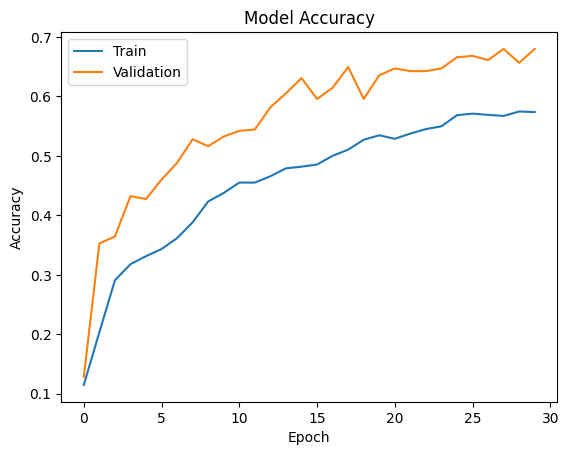

In [ ]:
# Model Evaluation
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* The validation dataset is slightly overfitting as the training dataset has a smoother line on the graph.
* The validation dataset has performed better than the train dataset.

In [ ]:
# Evaluating the model on test data
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

15/15 - 0s - loss: 1.0263 - accuracy: 0.6821 - 190ms/epoch - 13ms/step


In [ ]:
# Plotting a confusion matrix
y_pred=model1.predict(X_test_normalized)

15/15 [==============================] - 0s 4ms/step


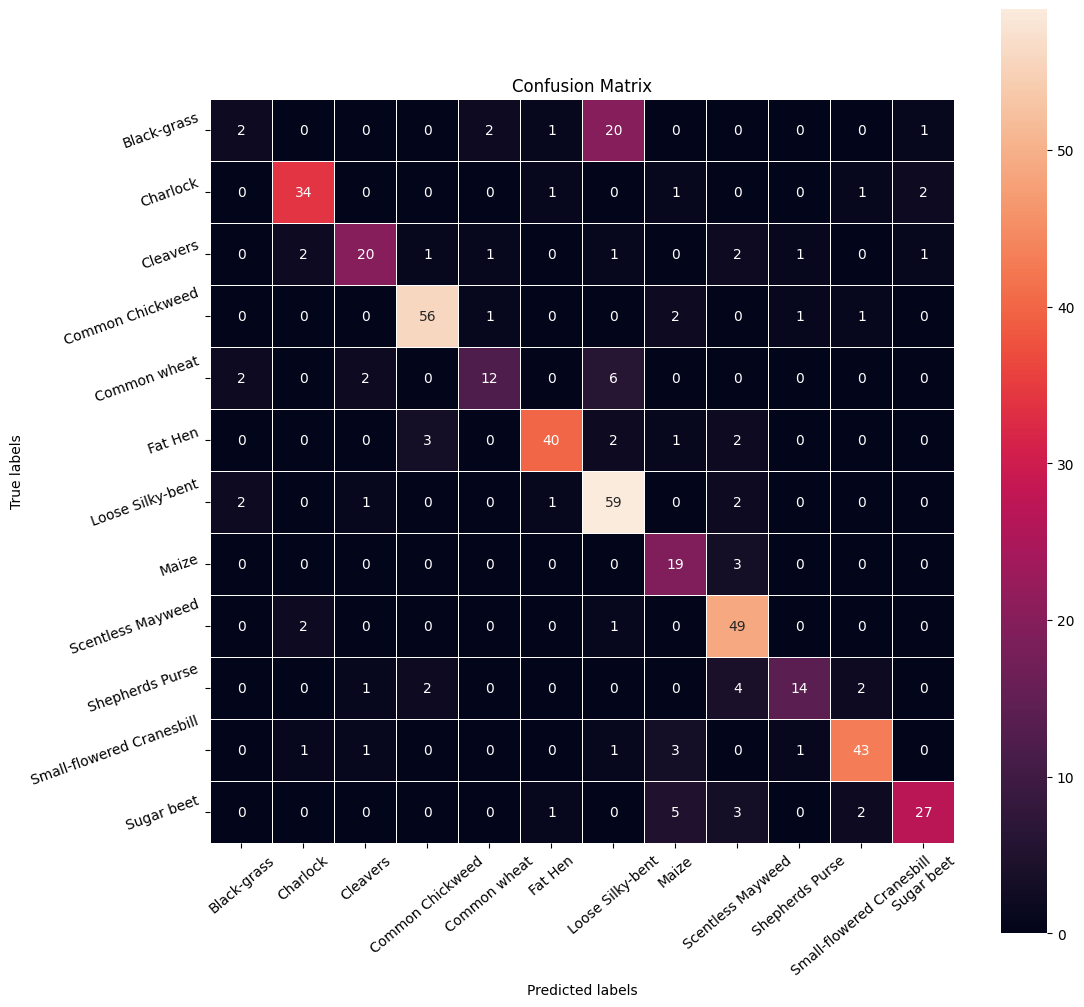

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)              # Complete the code to plot the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

* From the above plot we see that most of the plant seedlings were correctly predicted.
* Black-grass and common wheat however were not accurately predicted.

In [ ]:
# Plotting the classification report
cr = metrics.classification_report(y_pred_arg, y_test_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.74      0.60      0.67        48
           2       0.41      0.48      0.44        25
           3       0.92      0.80      0.85        70
           4       0.00      0.00      0.00         0
           5       0.75      0.78      0.77        46
           6       0.95      0.55      0.70       112
           7       0.55      0.80      0.65        15
           8       0.77      0.67      0.71        60
           9       0.43      0.71      0.54        14
          10       0.72      0.88      0.79        41
          11       0.82      0.70      0.76        44

    accuracy                           0.68       475
   macro avg       0.59      0.58      0.57       475
weighted avg       0.79      0.68      0.72       475



## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [ ]:
# Intializing a sequential model
model2 = Sequential()

# Complete the code to add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Complete the code to add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Complete the code to add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# Complete the code to add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Complete the code to initialize Adam Optimimzer
opt="adam"
# Complete the code to Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
# Fitting the model on the train data
# Complete the code to fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 7s 75ms/step - loss: 2.3276 - accuracy: 0.1787 - val_loss: 2.4356 - val_accuracy: 0.1308 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 4s 70ms/step - loss: 1.8484 - accuracy: 0.3661 - val_loss: 2.3897 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 4s 69ms/step - loss: 1.5681 - accuracy: 0.4581 - val_loss: 2.3176 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 5s 91ms/step - loss: 1.4381 - accuracy: 0.5046 - val_loss: 2.1479 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 4s 70ms/step - loss: 1.3188 - accuracy: 0.5482 - val_loss: 2.0285 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 5s 79ms/step - loss: 1.2480 - accuracy: 0.5586 - val_loss: 1.7633 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 5s 81ms/step - loss: 1.1

* By reducing the learning rate the training accuracy increased to 76% while the validation accuracy increased to 79%.

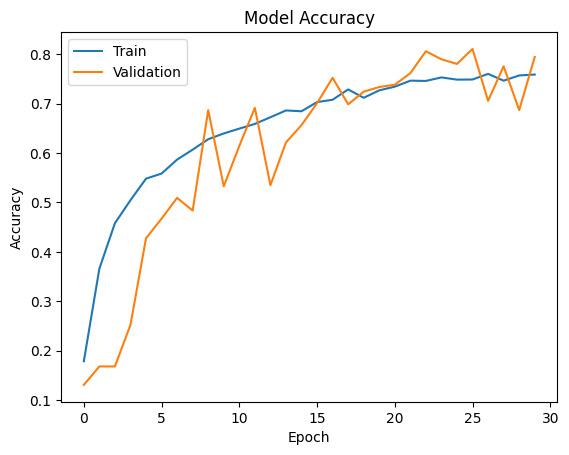

In [ ]:
# Model Evaluation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* As per the graph, the validation set is still overfitting.
* The accuracy of both datasets is similiar.
* The accuracy of the train dataset increased as compared to model 1.

In [ ]:
# Evaluating the model on test data
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # Complete the code to evaluate the model on test data

15/15 - 0s - loss: 0.6800 - accuracy: 0.7895 - 236ms/epoch - 16ms/step


In [ ]:
# Plotting a confusion matrix
# Complete the code to obtain the output probabilities
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


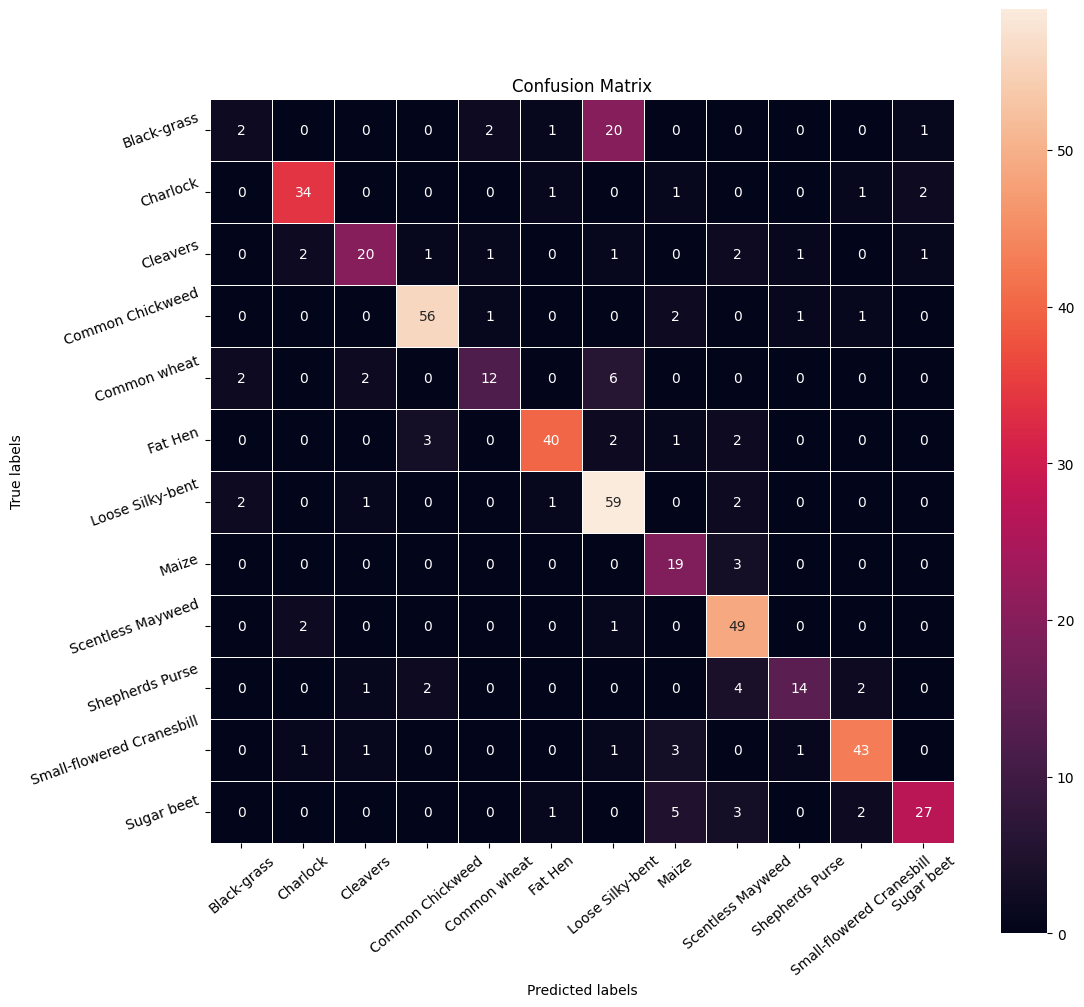

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [ ]:
# Plotting Classification Report
cr=metrics.classification_report(y_pred_arg,y_test_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.08      0.33      0.12         6
           1       0.87      0.87      0.87        39
           2       0.69      0.80      0.74        25
           3       0.92      0.90      0.91        62
           4       0.55      0.75      0.63        16
           5       0.83      0.91      0.87        44
           6       0.91      0.66      0.76        90
           7       0.86      0.61      0.72        31
           8       0.94      0.75      0.84        65
           9       0.61      0.82      0.70        17
          10       0.86      0.88      0.87        49
          11       0.71      0.87      0.78        31

    accuracy                           0.79       475
   macro avg       0.74      0.76      0.73       475
weighted avg       0.84      0.79      0.80       475



## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

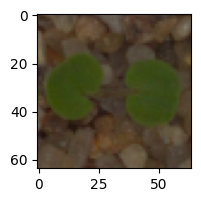

1/1 [==============================] - 0s 84ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


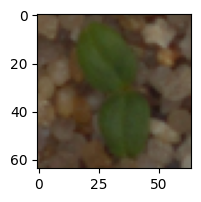

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Cleavers']
True Label Cleavers


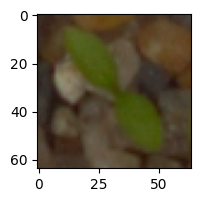

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


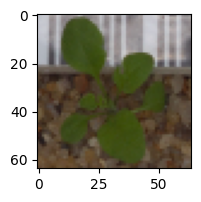

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

### Visualizing the prediction

## Actionable Insights and Business Recommendations

* My final model has an accuracy of 79%.
* This means that almost 8 out 10 plant seedling will be able to be correctly identified. This will save time and reduce the amount of effort required to identify the seedlings aided by AI and Deep Learning.
* The model may be improved through training with different filter sizes and increasing the number of filters.
* The model could be trained on the original image size (128x128).
* Further data augmentation could be performed with an increased drop_out rate to improve performance.
* Transfer learning may also imprive performance for this CNN model.   

_____